In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
import pymongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from matplotlib import pyplot as plt
from PIL import Image
import os
import json
import re
from matplotlib import pyplot as plt


tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b-it")
img_dir='images'
descr_fpath='descriptions.json'
pattern = r"\d+\.png"
embedding_model = SentenceTransformer("thenlper/gte-large")
uri = "your mongodb cluster uri"


In [3]:
descriptions = list(json.load(open(descr_fpath, mode="r")).items())
    
lines=[]

for description in descriptions:
    if not description[1].strip():
        continue
    lines.append(f"The image id is {description[0]} and it's description is {description[1]}")

df=pd.DataFrame(lines,columns=['text'])

In [4]:

def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "queryVector": query_embedding,
                "path": "embedding",
                "numCandidates": 150,  # Number of candidate matches to consider
                "limit": 4,  # Return top 4 matches
            }
        },
        {
            "$project": {
                "text": 1,  # Include the plot field
                "score": {"$meta": "vectorSearchScore"},  # Include the search score
            }
        },
    ]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

def get_search_result(query, collection):

    get_knowledge = vector_search(query, collection)

    search_result = ""
    for result in get_knowledge:
        search_result += f"{result.get('text')}\n"

    return search_result


def get_embedding(text: str) -> list[float]:
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    embedding = embedding_model.encode(text)

    return embedding.tolist()


def get_mongo_client(mongo_uri):
    """Establish connection to the MongoDB."""
    try:
        client = pymongo.MongoClient(mongo_uri)
        print("Connection to MongoDB successful")
        return client
    except pymongo.errors.ConnectionFailure as e:
        print(f"Connection failed: {e}")
        return None



In [5]:
df=df.dropna()
df["embedding"] = df["text"].apply(get_embedding)
df.head()

,text,embedding
0,The image id is 0.png and it's description is ...,"[-0.011653206311166286, -0.0009262313833460212..."
1,The image id is 1.png and it's description is ...,"[-0.0015851380303502083, -0.022696392610669136..."
2,The image id is 2.png and it's description is ...,"[-0.001687648706138134, 0.010688593611121178, ..."
3,The image id is 3.png and it's description is ...,"[0.0012346262810751796, -0.010996244847774506,..."
4,The image id is 4.png and it's description is ...,"[-0.027509843930602074, -0.003390246070921421,..."


In [6]:
mongo_client = MongoClient(uri, server_api=ServerApi('1'))

# Ingest data into MongoDB
db = mongo_client["dataset_rag"]
collection = db["dataset_rag_collections"]
collection.delete_many({})
documents = df.to_dict("records")
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


Query:Is there any mention of Saturn ? , If so mention it's image id and description 

############################################################ 

Source information:
The image id is 150.png and it's description is Plate showing a view of the planet Saturn with its ring system at a slight angle. Saturn is described as follows by the author:[1]
Seen with the naked eye, Saturn shines in the night like a star of the first magnitude, whose dull, soft whiteness is, however, far from attaining the brilliancy of Venus or Jupiter, although it sometimes approaches Mars in brightness. Saturn hardly ever exhibits the phenomenon of scintillation, or twinkling, a peculiarity which makes it easily distinguishable among the stars and planets of the heavens.


^ The Trouvelot astronomical drawings manual. Trouvelot, Étienne Léopold. New York: Charles Scribner’s sons, 1882, p. 83.



The image id is 148.png and it's description is Plate showing a shower of Leonid meteors observed in November 1868. T

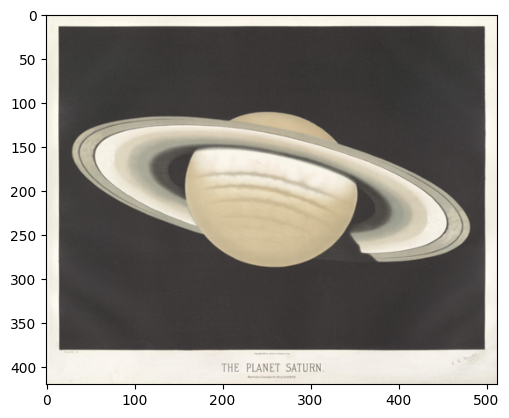

In [8]:
query="Is there any mention of Saturn ? , If so mention it's image id and description"
source_information = get_search_result(query, collection)
combined_information=f"Based on the context {source_information}\n  ,{query}"


input_ids = tokenizer(combined_information, return_tensors="pt")
response = tokenizer.decode(model.generate(**input_ids, max_new_tokens=500)[0])
answer=response.split(combined_information)[-1]
img_ids = re.findall(pattern,answer)
print(f"Query:{query} \n")
print('############################################################ \n')
print(f"Source information:\n{source_information} \n")
print('############################################################ \n')
print(f"Answer:{answer} \n")
for img_id in list(set(img_ids)):
    print('Associated Image:',img_id)
    img=Image.open(os.path.join(img_dir,img_id))
    plt.imshow(img)
    plt.show()


In [ ]:
'''

## Cosine similarity with numpy or scipy, if MongoDB is not required ##

import numpy as np
from scipy.spatial.distance import cdist

def cosine_similarity_numpy(a, b):
    a=a/np.linalg.norm(a, axis=1, keepdims=True)
    b=b/np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a, b.T)



a= np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b= np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(a.shape,b.shape)
cosine_sim=cosine_similarity_numpy(a,b)
print(cosine_sim)
cosine_sim = 1 - cdist(a, b, metric='cosine')
print(cosine_sim)


'''